In [1]:
import os
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import tensorflowjs as tfjs

In [2]:
# from PIL import Image
# from io import BytesIO
# from uuid import uuid4

# train_df = pd.read_parquet("/Users/joshua/Documents/affectnet_short/data/train-00000-of-00001-7cbcbf03ccc4c14c.parquet")
# val_df = pd.read_parquet("/Users/joshua/Documents/affectnet_short/data/val-00000-of-00001-15bd8d507ff5dd11.parquet")

# MAPPING = {0: "anger", 1: "surprise", 2: "contempt", 3: "happy", 4: "neutral", 5: "fear", 6: "sad", 7: "disgust"}
# for uniq in train_df.label.unique():
#     os.makedirs(f"quality_dataset/train/{MAPPING[uniq]}")
#     os.makedirs(f"quality_dataset/val/{MAPPING[uniq]}")

# def save_img(row, mode): 
#     im = Image.open(BytesIO(row.image["bytes"]))
#     im.save(os.path.join(f"./quality_dataset/{mode}", MAPPING[row.label], str(uuid4()) + ".jpg"))

# _ = train_df.apply(lambda x: save_img(x, "train"), axis = 1)
# _ = val_df.apply(lambda x: save_img(x, "val"), axis = 1)

In [3]:
train_dir = "/Users/joshua/Desktop/quality_dataset/train"
val_dir = "/Users/joshua/Desktop/quality_dataset/val"


# Execute augmentation lazily.
@tf.function
def data_augmentation(images, labels):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_saturation(images, 0.65, 1.45)
  images = tf.image.random_brightness(images, max_delta=0.3)
  return images, labels

# Create training generator.
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32)
LABEL_MAP = dict(enumerate(train_ds.class_names))
train_ds = train_ds.map(data_augmentation)

# Create validation generator.
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32, validation_split=0.5, subset="training", seed = 2024)
test_ds = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32, validation_split=0.5, subset="validation", seed = 2024)


# Prefetch for loading speed.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10677 files belonging to 3 classes.
Found 2669 files belonging to 3 classes.
Using 1335 files for training.
Found 2669 files belonging to 3 classes.
Using 1334 files for validation.


In [57]:
# counts = {}
# for label in ["happy", "fear", "neutral"]:
#     counts[label] = len(os.listdir(f"/Users/joshua/Desktop/quality_dataset/train/{label}"))
# counts

2024-02-05 10:26:03.895825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


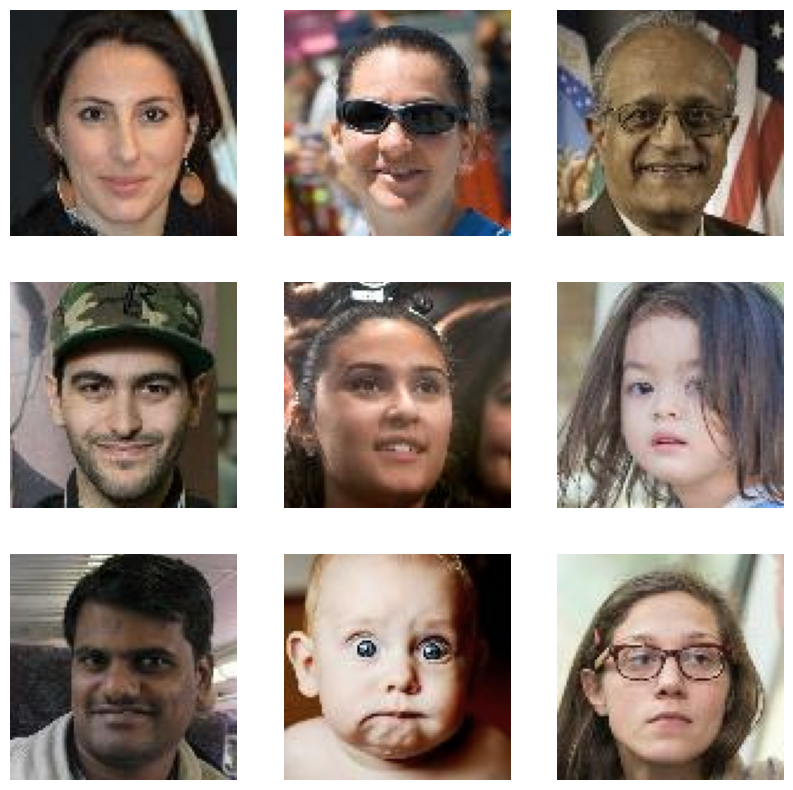

In [4]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model


# def build_cnn(conv_blocks=3, classifier_blocks = 2, filters=64, kernel_size=3, input_shape=(96,96,3), 
#               pool_size=2, dense_units=64, num_classes=6, dropout_rate=0.2, **kwargs):
        
#     inputs = Input(shape=input_shape)
#     x = tf.keras.layers.Rescaling(1./255)(inputs)
#     x = tf.keras.layers.RandomFlip("horizontal")(x)
#     x = tf.keras.layers.RandomRotation(0.1)(x)

#     # Add convolutional blocks
#     for _ in range(conv_blocks):
 
#         x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding = "same", kernel_regularizer=tf.keras.regularizers.l2())(x)
#         x = MaxPooling2D(pool_size=pool_size)(x)
#         x = BatchNormalization()(x)
#         x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)   
#         x = Dropout(dropout_rate)(x)
        
#     x = Flatten()(x)

#     # Add classifier head.
#     for _ in range(classifier_blocks):
#         x = Dense(units=dense_units)(x)
#         x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
#         x = Dropout(dropout_rate)(x)

#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     # Define the model
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

def build_feature_cnn(input_shape=(96,96,3), num_classes=3):
    
    # Define feature extraction layer.
    feature_extractor = tf.keras.applications.EfficientNetV2S(input_shape = input_shape, include_top = False)
    feature_extractor.trainable = False

    # Assemble model with classification head.
    inputs = Input(shape=input_shape)
    x = feature_extractor(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1280, activation="tanh")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    return model


In [ ]:
# Get class weights


In [56]:
model = build_feature_cnn()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate = 0.015), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_ds, validation_data = val_ds, epochs = 40, callbacks = [early_stopping], class_weight = {0: 1.6, 1: 1, 2: 1})

Epoch 1/40
334/334 [==============================] - 76s 196ms/step - loss: 1.1757 - accuracy: 0.5192 - val_loss: 0.8422 - val_accuracy: 0.6172
Epoch 2/40
334/334 [==============================] - 45s 135ms/step - loss: 0.8668 - accuracy: 0.6414 - val_loss: 0.7659 - val_accuracy: 0.6532
Epoch 3/40
334/334 [==============================] - 38s 113ms/step - loss: 0.7735 - accuracy: 0.6824 - val_loss: 0.7180 - val_accuracy: 0.6839
Epoch 4/40
334/334 [==============================] - 37s 112ms/step - loss: 0.7073 - accuracy: 0.7141 - val_loss: 0.6852 - val_accuracy: 0.6981
Epoch 5/40
334/334 [==============================] - 39s 116ms/step - loss: 0.6519 - accuracy: 0.7380 - val_loss: 0.6659 - val_accuracy: 0.7079
Epoch 6/40
334/334 [==============================] - 39s 116ms/step - loss: 0.6019 - accuracy: 0.7597 - val_loss: 0.6542 - val_accuracy: 0.7191
Epoch 7/40
334/334 [==============================] - 39s 117ms/step - loss: 0.5545 - accuracy: 0.7777 - val_loss: 0.6437 - val_ac

In [58]:
import plotly.express as px

fig = px.line(history.history, height = 800, width = 1000)
fig.update_layout(
    template = "plotly_white", 
    yaxis_title='',
    xaxis_title='Epoch',
    yaxis_range=(0, 1),
    title = "Training Epochs",
    legend_title = "Monitored Value"
)

In [59]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "webcam/public/model")

/opt/homebrew/Caskroom/miniforge/base/envs/emotions/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [60]:
%%capture
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

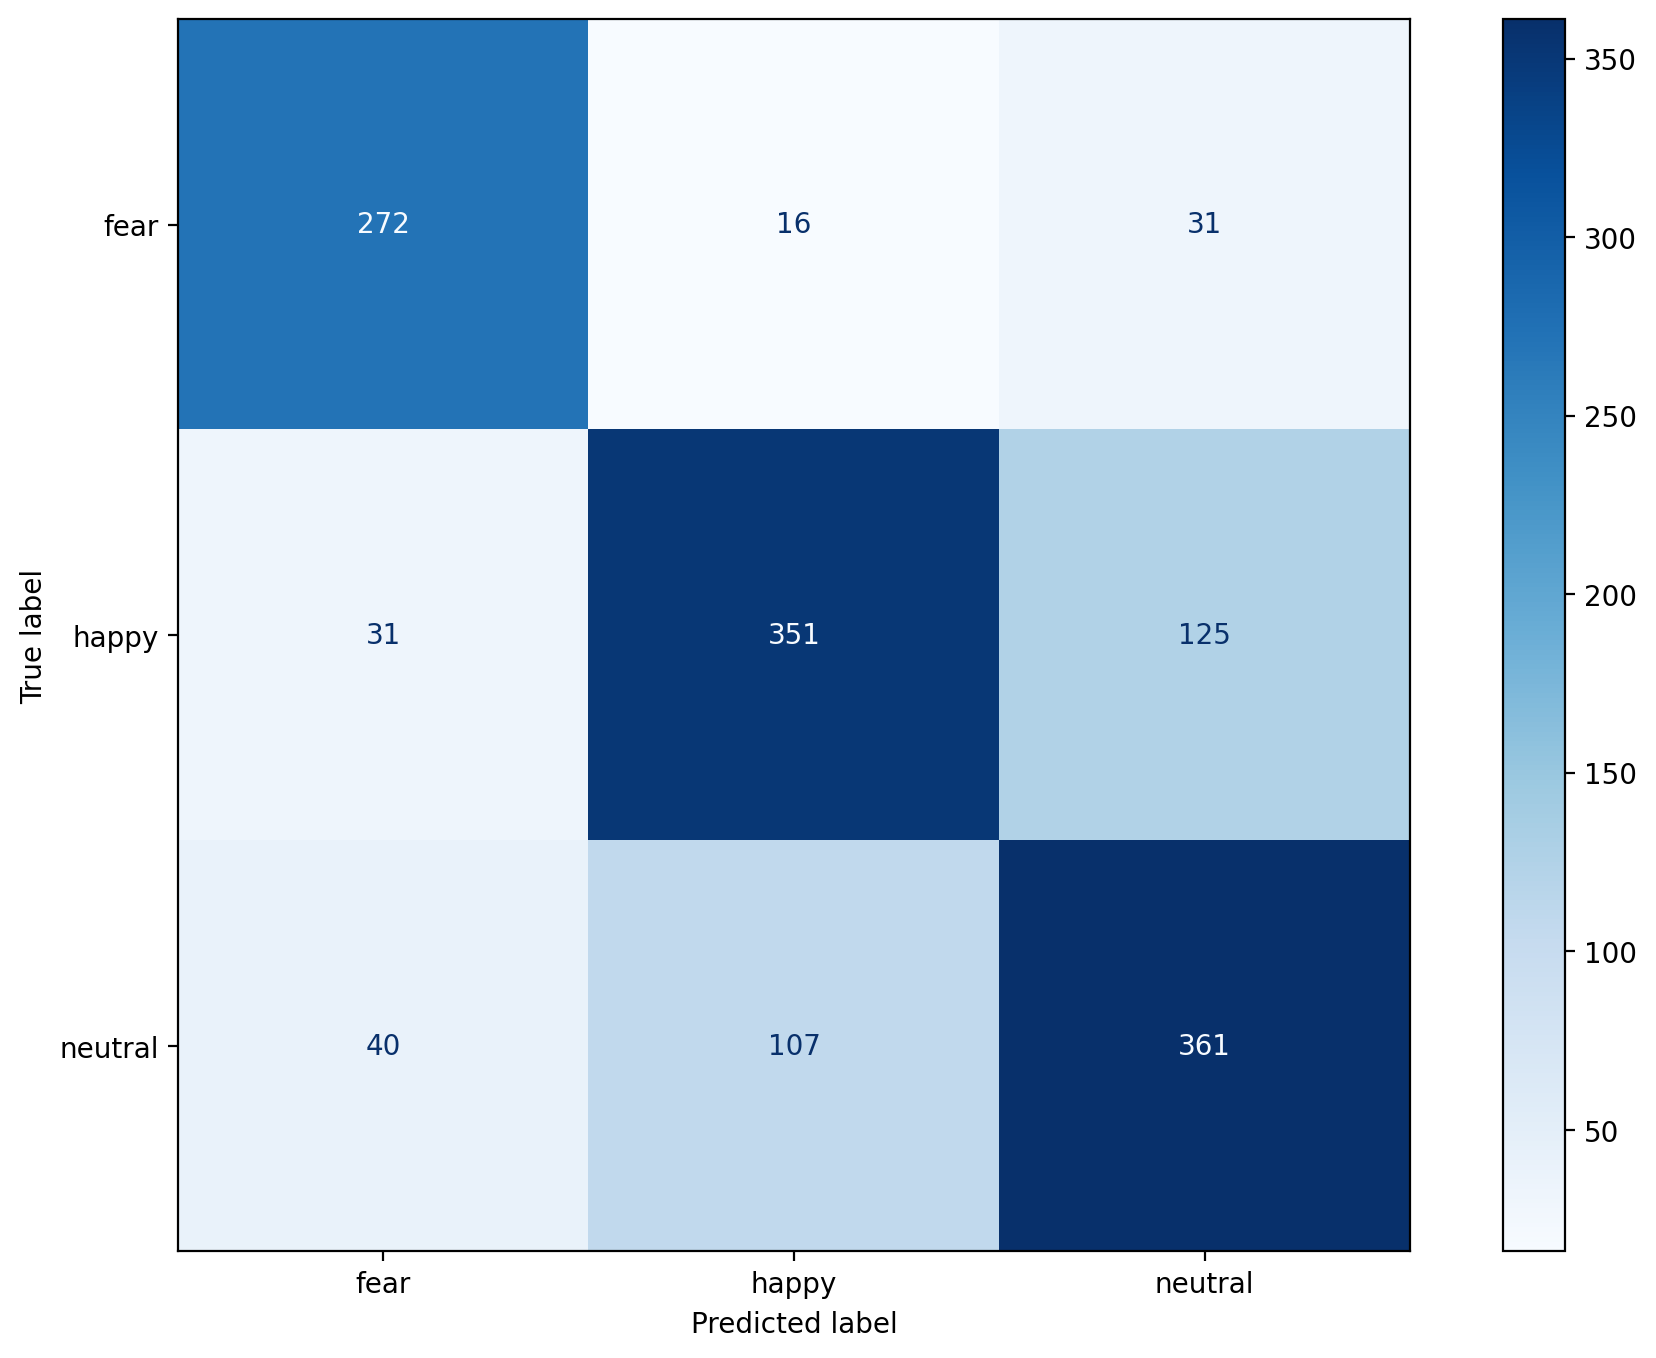

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(LABEL_MAP.values()))
disp.plot(cmap=plt.cm.Blues)
fig =plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(200)
plt.show()

In [63]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(predictions, labels, class_names):
    # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = predictions.shape[1]
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Create fig
    fig = go.Figure()

    # Plot all ROC curves in the same figure
    for i in range(n_classes):
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i])))
    
    # add diagonal line
    fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='random', line=dict(dash='dash')))

    # update layout
    fig.update_layout(
        template = "plotly_white",
        xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                      title=f'Emotions ROC (n = {len(predictions)})', 
                      autosize=False,
                      width=900, 
                      height=800)
    
    fig.show()

plot_roc_curves(predictions, labels, ["fear", "happy", "neutral"])

IndexError: tuple index out of range

In [52]:
import plotly.io as pio
list(pio.templates) 

['ggplot2',
 'seaborn',
 'simple_white',
 'plotly',
 'plotly_white',
 'plotly_dark',
 'presentation',
 'xgridoff',
 'ygridoff',
 'gridon',
 'none']

In [24]:
# tfjs.converters.save_keras_model(model, a"./webcam/src/models/emotions.tfjs")

In [30]:
# from PIL import Image
# from IPython.display import display
# test_ds = tf.keras.utils.image_dataset_from_directory('test_images', image_size=(96, 96))

# for x, y in val_ds:
#     predictions = model.predict(x)

#     for img, pred, true in zip(x, predictions, y):
#         casted = np.asarray(img, dtype = np.float32)
#         im = Image.fromarray((casted).astype(np.uint8))
#         plt.figure()
#         plt.imshow(im)
#         plt.show()
#         print("Prediction: ", LABEL_MAP[np.argmax(pred)])
#         print(true)
#         print("True: ", LABEL_MAP[np.argmax(true.numpy())])
#         print("-----")

#     break

In [ ]:
print(LABEL_MAP)

In [ ]:
# import random

# conv = lambda: random.choice(list(range(2, 7)))
# classifiers = lambda: random.choice(list(range(2, 4)))
# filters = lambda: random.choice([32, 64, 128])
# kernel_size = lambda: random.choice([3, 6])
# dense_units = lambda: random.choice([32, 64, 128, 256])
# dropout_rate = lambda: random.choice([0.1, 0.2, 0.3])
# regularization = lambda: random.choice([None, "l1", "l2", "l1_l2"])
# lr = lambda: random.choice([0.001, 0.01, 0.1])

# config = {
#     "conv_block": conv(),
#     "classifier_blocks": classifiers(),
#     "filters": filters(),
#     "kernel_size": kernel_size(),
#     "dense_units": dense_units(),
#     "dropout_rate": dropout_rate(),
#     "regularization": regularization(),
#     "learning_rate": lr()
# }